In [1]:
import os, glob, sys,datetime

import xarray as xr
import numpy as np

os.chdir('/home/peter/Projects/data/ERA5/')

In [2]:
fillin_size = 3
tracks = xr.open_dataset('../IBTrACS.NA.v04r00.nc')

In [82]:
var_name = '151'
level = ''
given_var_name = 'MSLP'

In [20]:
var_name = '131'
level = '_20000'
given_var_name = 'u200'

In [3]:
var_name = '131'
level = '_85000'
given_var_name = 'u850'

In [21]:
data_in = xr.open_dataset('/home/peter/Projects/data/ERA5/ERA5_%s%s_atl_1x1_6h.nc' %(var_name,level))['var'+var_name].squeeze()
data_remTC = data_in.copy()

In [22]:
data_in

<xarray.DataArray 'var131' (time: 14612, lat: 45, lon: 111)>
[72986940 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1982-08-01T02:30:00 ... 2021-10-31T20:30:00
  * lon      (lon) float64 -110.0 -109.0 -108.0 -107.0 ... -3.0 -2.0 -1.0 0.0
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 40.5 41.5 42.5 43.5 44.5
    plev     float64 2e+04
Attributes:
    code:     131
    table:    128

In [23]:
###########################
# remove TCs
###########################
relevant = np.isfinite(tracks['lon']) & \
                (np.isin(tracks['time'].dt.year,np.unique(data_in.time.dt.year))) &\
                (tracks['wmo_wind'] >= 34) & \
                (np.isin(tracks['time'].dt.month,[8,9,10]))

In [24]:
for storm,time in zip(np.where(relevant)[0],np.where(relevant)[1]):
    t,y,x = tracks.time[storm,time].values,tracks.lat[storm,time].values,tracks.lon[storm,time].values
    t_nearest = data_remTC.time.sel(time=t, method='nearest').values
    tmp = data_remTC.sel(time=t_nearest, lat=slice(y-fillin_size,y+fillin_size), lon=slice(x-fillin_size,x+fillin_size))
    tmp.values = tmp.values.copy() * np.nan
    data_remTC.loc[t_nearest,tmp.lat,tmp.lon] = np.nan
    fill_value = np.nanmean(data_remTC.sel(time=t_nearest, lat=slice(y-fillin_size-1,y+fillin_size+1), lon=slice(x-fillin_size-1,x+fillin_size+1)))
    data_remTC.loc[t_nearest,tmp.lat,tmp.lon] = fill_value

/tmp/ipykernel_154691/1896771311.py:7: RuntimeWarning: Mean of empty slice
  fill_value = np.nanmean(data_remTC.sel(time=t_nearest, lat=slice(y-fillin_size-1,y+fillin_size+1), lon=slice(x-fillin_size-1,x+fillin_size+1)))


In [25]:
dayID = np.array([str(d)[:10] for d in data_remTC.time.values], np.datetime64)
data_remTC = data_remTC.assign_coords(time = dayID)
data_remTC = data_remTC.groupby('time').mean('time')

In [26]:
xr.Dataset({given_var_name:data_remTC}).to_netcdf('/home/peter/Projects/data/ERA5/ERA5_%s_atl_1x1_daily_rmTC.nc' %(given_var_name))

## VWS

In [27]:
u200 = xr.open_dataset('/home/peter/Projects/data/ERA5/ERA5_u200_atl_1x1_daily_rmTC.nc')['u200']
u850 = xr.open_dataset('/home/peter/Projects/data/ERA5/ERA5_u850_atl_1x1_daily_rmTC.nc')['u850']
vws = u200 - u850

In [28]:
xr.Dataset({'vws':vws}).to_netcdf('/home/peter/Projects/data/ERA5/ERA5_vws_atl_1x1_daily_rmTC.nc')

In [29]:
u200.time

<xarray.DataArray 'time' (time: 3653)>
array(['1982-08-01T00:00:00.000000000', '1982-08-02T00:00:00.000000000',
       '1982-08-03T00:00:00.000000000', ..., '2021-10-29T00:00:00.000000000',
       '2021-10-30T00:00:00.000000000', '2021-10-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    plev     float64 ...
  * time     (time) datetime64[ns] 1982-08-01 1982-08-02 ... 2021-10-31

In [10]:
mslp = xr.open_dataset('/home/peter/Projects/data/ERA5/ERA5_MSLP_atl_1x1_daily_rmTC.nc')['MSLP']

In [11]:
# for plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

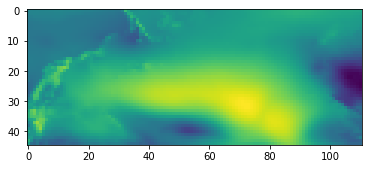

In [12]:
plt.imshow(mslp[0,:,:])
plt.show()

In [13]:
%matplotlib notebook

In [14]:
from matplotlib.animation import FuncAnimation

In [19]:
fig, ax = plt.subplots()
line, = ax.plot([])     # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)

def animate(frame_num):
    y = np.sin(x + 2*np.pi * frame_num/100)
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=100, interval=20)
plt.show()

<IPython.core.display.Javascript object>